# VGG19 Training

In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt
import gc
import joblib

2024-12-13 08:38:06.174059: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734079087.052991   11839 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734079087.268195   11839 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-13 08:38:09.382283: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Check GPU accelaration

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print(f"Memory growth set for GPU: {gpu}")
    except RuntimeError as e:
        print(e)

Memory growth set for GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [14]:
IMG_SIZE = 224
BATCH_SIZE = 8
EPOCHS = 100

# preprocessing the dataset

In [15]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory('Birds_25/train',
                                                              shuffle=True,
                                                              image_size = (IMG_SIZE,IMG_SIZE),
                                                              batch_size = BATCH_SIZE)

Found 30000 files belonging to 25 classes.


I0000 00:00:1734079153.510595   11839 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [5]:
class_name = train_ds.class_names

class_name
joblib.dump(class_name, "models/keras_vgg19/class_name.pkl")

['models/keras_vgg19/class_name.pkl']

In [6]:
test_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory('Birds_25/valid',
                                                                      shuffle=True,
                                                                      image_size=(
                                                                          IMG_SIZE, IMG_SIZE),
                                                                      batch_size=BATCH_SIZE,
                                                                      seed=42,
                                                                      subset='both',
                                                                      validation_split=0.50)

Found 7500 files belonging to 25 classes.
Using 3750 files for training.
Using 3750 files for validation.


In [7]:
data_directory = "Birds_25/train"
class_len = []

for name in class_name:
    class_length = len(list(tf.data.Dataset.list_files(
        data_directory + '/' + name + '/*')))
    print(f"Class {name}: {class_length} samples")
    class_len.append(class_length)

2024-12-13 07:46:00.702694: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Class Asian-Green-Bee-Eater: 1200 samples


2024-12-13 07:46:01.259274: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Class Brown-Headed-Barbet: 1200 samples
Class Cattle-Egret: 1200 samples


2024-12-13 07:46:02.317734: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Class Common-Kingfisher: 1200 samples
Class Common-Myna: 1200 samples
Class Common-Rosefinch: 1200 samples
Class Common-Tailorbird: 1200 samples


2024-12-13 07:46:04.497642: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Class Coppersmith-Barbet: 1200 samples
Class Forest-Wagtail: 1200 samples
Class Gray-Wagtail: 1200 samples
Class Hoopoe: 1200 samples
Class House-Crow: 1200 samples
Class Indian-Grey-Hornbill: 1200 samples
Class Indian-Peacock: 1200 samples
Class Indian-Pitta: 1200 samples


2024-12-13 07:46:08.937036: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Class Indian-Roller: 1200 samples
Class Jungle-Babbler: 1200 samples
Class Northern-Lapwing: 1200 samples
Class Red-Wattled-Lapwing: 1200 samples
Class Ruddy-Shelduck: 1200 samples
Class Rufous-Treepie: 1200 samples
Class Sarus-Crane: 1200 samples
Class White-Breasted-Kingfisher: 1200 samples
Class White-Breasted-Waterhen: 1200 samples
Class White-Wagtail: 1200 samples


In [8]:
len(test_ds),len(val_ds)

(469, 469)

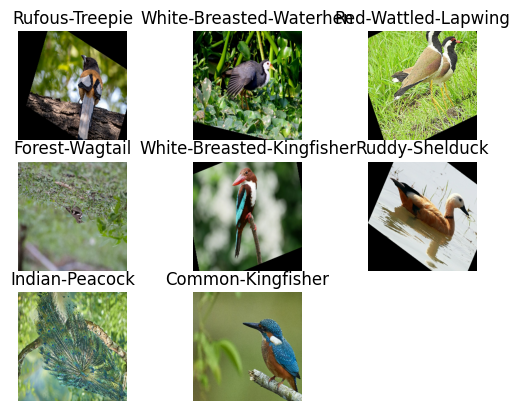

In [9]:
for image,label in train_ds.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(3,3,i+1)
        plt.title(class_name[label[i]])
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.axis('off')

In [10]:
rescale_resize = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMG_SIZE,IMG_SIZE),
    tf.keras.layers.Rescaling(1.0/255)
])
pre_trained_model = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3),
    pooling='average',
    classes=25,
    classifier_activation="softmax",
)
for layers in pre_trained_model.layers[:17]:
    layers.trainable=False

In [11]:
# Define a function to apply data augmentation to an image
def augment_image(image, label):
    # Randomly adjust the brightness of the image
    image = tf.image.random_brightness(image, max_delta=0.2)

    # Randomly rotate the image
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    return image, label

In [12]:
# Assuming x_train and y_train are already created as tf.data.Dataset batches
# Apply data augmentation to the training data
augmented_train_ds = train_ds.map(augment_image)
CHANNELS = 3
INPUT_SHAPE = (BATCH_SIZE,IMG_SIZE,IMG_SIZE,CHANNELS)


model = tf.keras.models.Sequential([
    rescale_resize,
    pre_trained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(200,activation='relu',kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.07),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100,activation='relu',kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.03),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(25,activation="softmax")
])

model.build(input_shape=INPUT_SHAPE)

In [13]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (8, 224, 224, 3)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (8, 7, 7, 512)         │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (8, 512)               │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (8, 512)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (8, 512)               │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (8, 200)               │       102,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (8, 200)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (8, 200)               │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (8, 100)               │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (8, 100)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (8, 100)               │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (8, 25)                │         2,525 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,152,857 (76.88 MB)

 Trainable params: 9,566,081 (36.49 MB)

 Non-trainable params: 10,586,776 (40.39 MB)

In [ ]:
model.compile(optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0005,beta_1=0.9,beta_2=0.999,epsilon=1e-07), 
             loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics=['acc'])

In [ ]:
checkpoint_filepath = 'checkpoints/IB25_VGG19_checkpoint.keras'
val_acc_maxchkpnt = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_acc',
    mode='max',
    verbose=0,
    save_best_only=True)

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss",
    min_delta = 0.005,
    patience = 4,
    verbose = 1,
    mode="min",
    start_from_epoch = 20
)

In [ ]:
# Training
gc.collect()
tf.keras.backend.clear_session()

In [ ]:
history = model.fit(augmented_train_ds,validation_data=val_ds,epochs=EPOCHS,callbacks=[earlystop,val_acc_maxchkpnt])

In [ ]:
model.save('models/keras_vgg19/ib25_vgg19.keras')
joblib.dump(history,"models/keras_vgg19/history.pkl")

In [17]:
model.evaluate(test_ds)

I0000 00:00:1734076054.989313    3571 service.cc:148] XLA service 0x7f87c400ee40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734076055.014068    3571 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-12-13 07:47:35.533318: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734076056.022462    3571 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-13 07:47:40.395294: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng20{k2=1,k4=2,k5=1,k6=0,k7=0,k19=0} for conv (f32[8,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_con

468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - acc: 0.9216 - loss: 0.2899

2024-12-13 07:48:31.690130: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 898.56MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


469/469 ━━━━━━━━━━━━━━━━━━━━ 60s 79ms/step - acc: 0.9216 - loss: 0.2898


[0.28042587637901306, 0.920799970626831]

# graphing

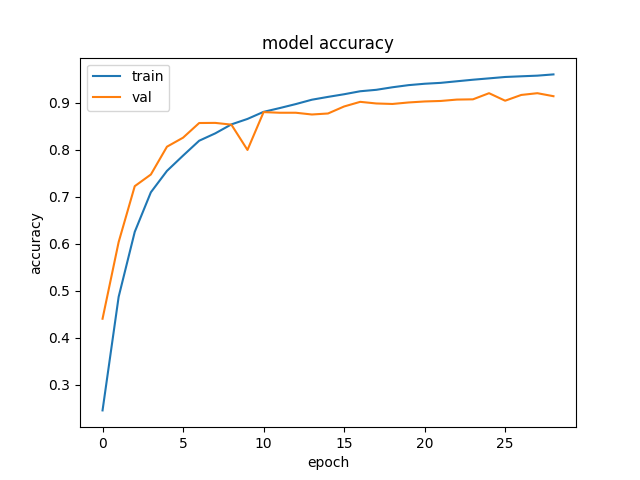

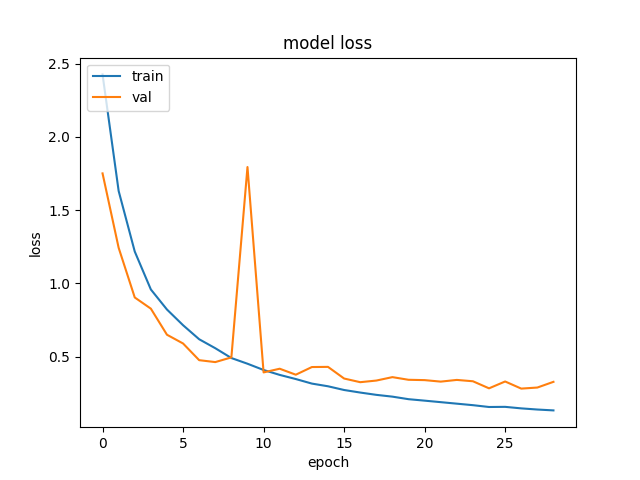

In [11]:
# Graphing
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("models/keras_vgg19/acc.png")
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("models/keras_vgg19/loss.png")
plt.show()

# Loading Testing

In [16]:
from IPython.display import clear_output
import joblib
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image

In [17]:
bird_model = tf.keras.models.load_model('models/keras_vgg19/ib25_vgg19.keras')

In [18]:
class_name = joblib.load('models/keras_vgg19/class_name.pkl')
class_name

['Asian-Green-Bee-Eater',
 'Brown-Headed-Barbet',
 'Cattle-Egret',
 'Common-Kingfisher',
 'Common-Myna',
 'Common-Rosefinch',
 'Common-Tailorbird',
 'Coppersmith-Barbet',
 'Forest-Wagtail',
 'Gray-Wagtail',
 'Hoopoe',
 'House-Crow',
 'Indian-Grey-Hornbill',
 'Indian-Peacock',
 'Indian-Pitta',
 'Indian-Roller',
 'Jungle-Babbler',
 'Northern-Lapwing',
 'Red-Wattled-Lapwing',
 'Ruddy-Shelduck',
 'Rufous-Treepie',
 'Sarus-Crane',
 'White-Breasted-Kingfisher',
 'White-Breasted-Waterhen',
 'White-Wagtail']

In [19]:
BATCH_SIZE = 8

In [20]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory('Birds_25/valid',
                                                              shuffle=True,
                                                              image_size=(224, 224),
                                                              batch_size=BATCH_SIZE,
                                                              seed=42,
                                                              )

Found 7500 files belonging to 25 classes.


In [21]:
y_true = []

y_pred = []

for image,label in test_ds:
    try:
        for i in range(BATCH_SIZE):
            img = np.expand_dims(image[i].numpy(),axis=0)
            y_pred.append(np.argmax(bird_model.predict(img)))
            y_true.append(label[i].numpy())
            clear_output(wait=True)
    except:
        print("Test method reached the end of testing dataset slices. Aborted for further runs.")

Test method reached the end of testing dataset slices. Aborted for further runs.


2024-12-13 08:51:38.653650: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at strided_slice_op.cc:117 : INVALID_ARGUMENT: slice index 4 of dimension 0 out of bounds.
2024-12-13 08:51:38.654906: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: slice index 4 of dimension 0 out of bounds.
2024-12-13 08:51:38.706185: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [22]:
clsrpt = classification_report(y_true,y_pred,target_names=class_name,output_dict=True)
confmat = confusion_matrix(y_pred, y_true)

<Axes: >

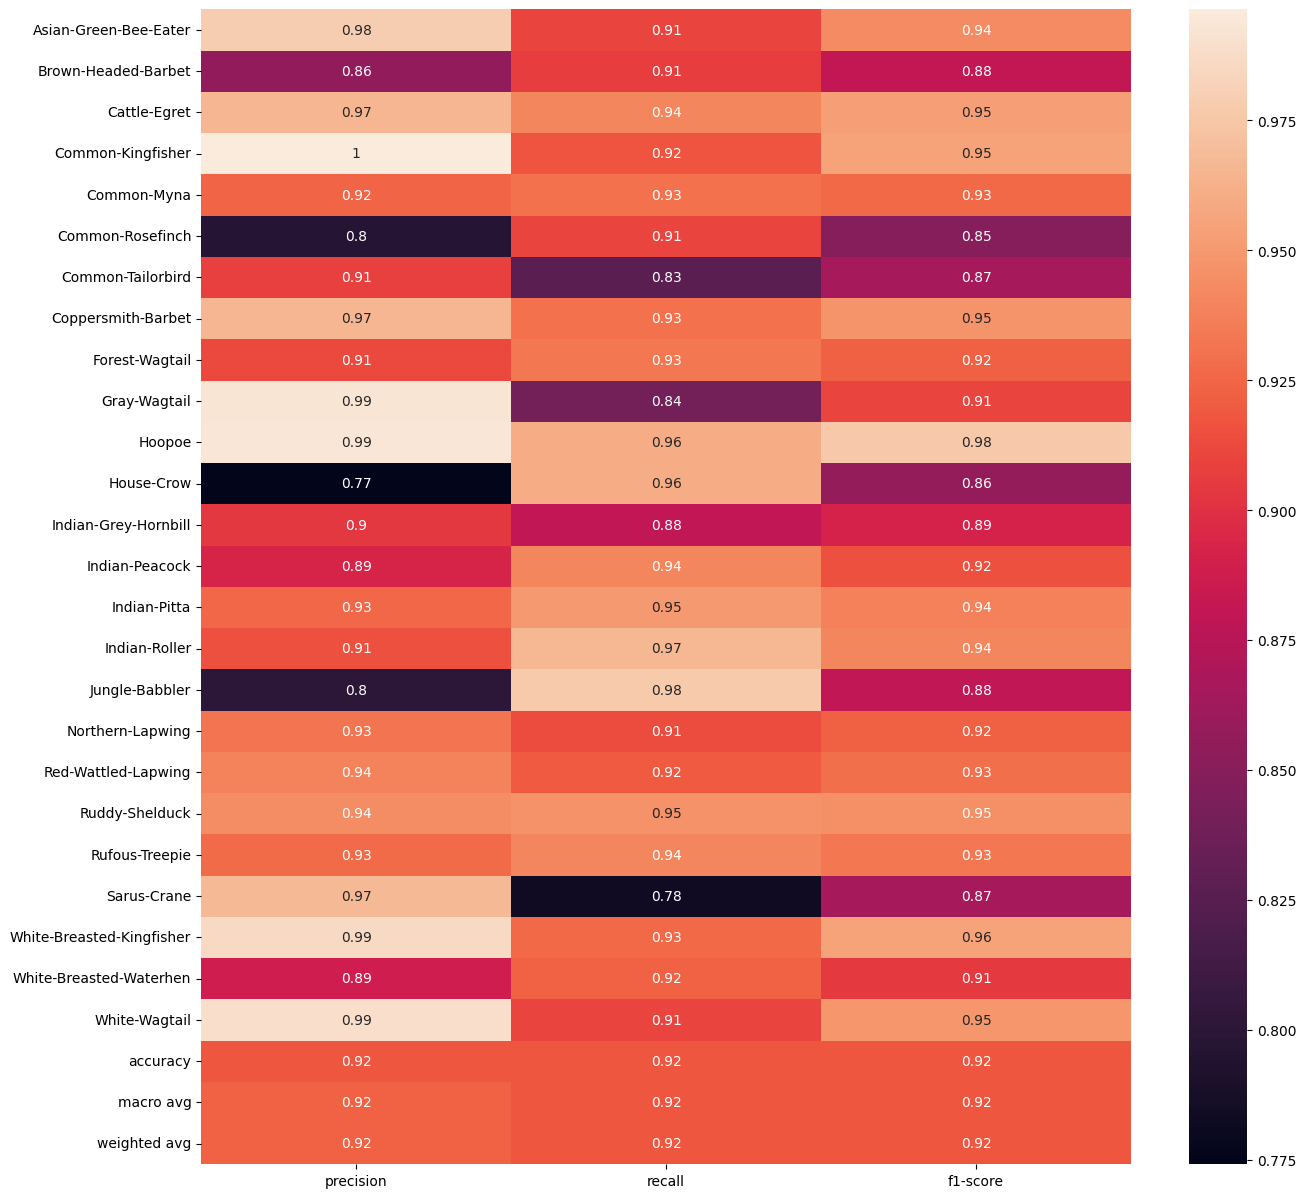

In [23]:
plt.figure(figsize=(15,15))

# we remove support to adjust the 
sns.heatmap(pd.DataFrame(clsrpt).iloc[:-1,:].T, annot=True)

<Axes: >

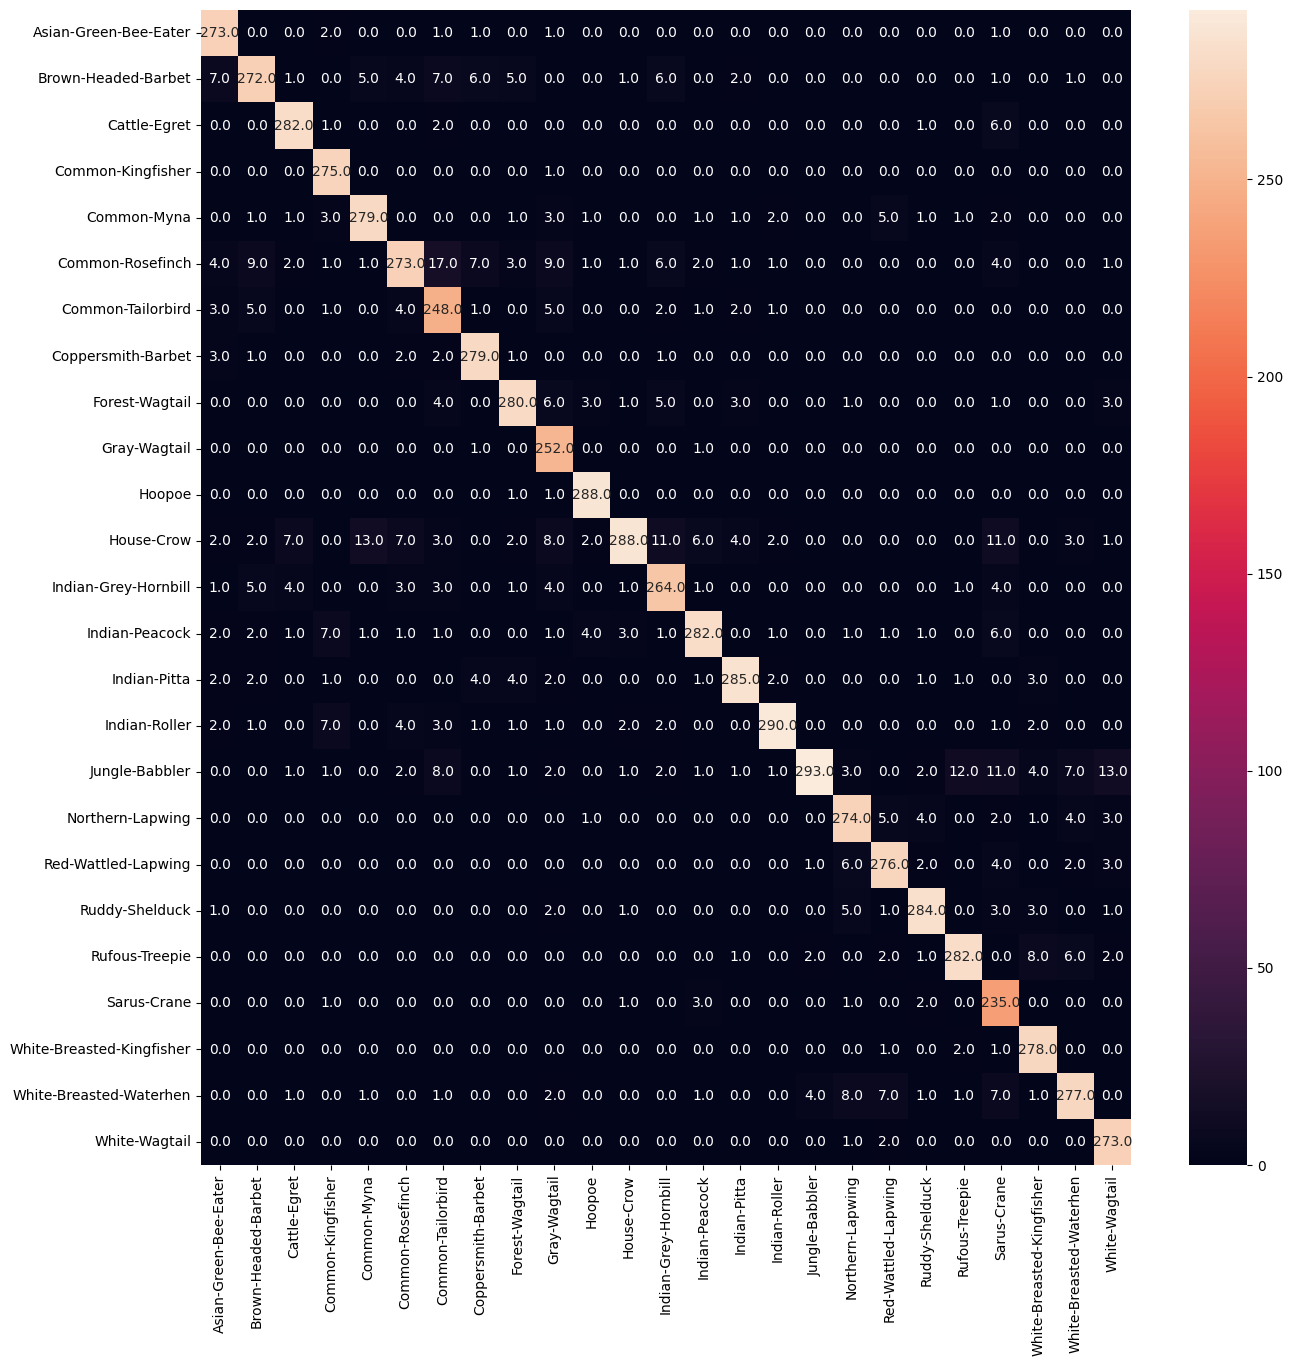

In [24]:
plt.figure(figsize=(15,15))
sns.heatmap(confmat, annot=True, fmt='.1f',xticklabels=class_name, yticklabels=class_name)

Testing on n online image

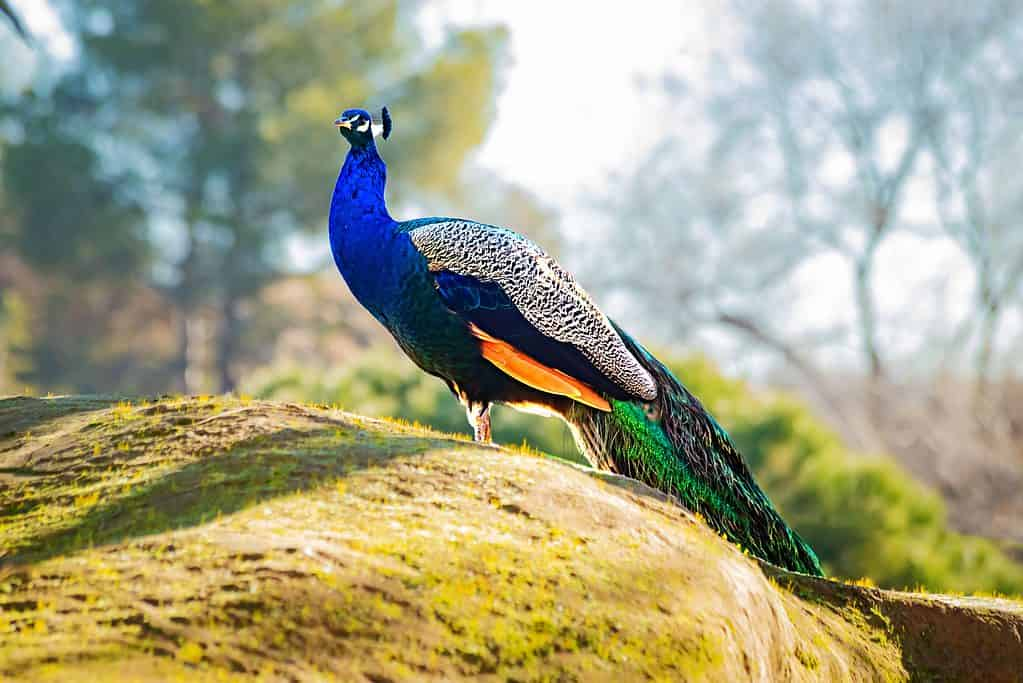

In [25]:
test = Image.open('test_images/indp.jpg')
test

In [26]:
test = tf.keras.preprocessing.image.img_to_array(test)
test = np.expand_dims(test,axis=0)
class_name[np.argmax(bird_model.predict(test))]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


'Indian-Peacock'